<a href="https://githubtocolab.com/Astolfo2332/shoe_classify/blob/main/00_data_setup.ipynb" target="_parent\">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" > </a>


## Actividad final deep learning

### - Miguel López Vélez
### - Francisco Belda Hériz
### - Carles Andrés Solanes
### - Ignacio Esplugues Conca

## 0.0 Descarga el dataset de Kaggle

In [2]:
import kagglehub
from tensorboard.notebook import display

path = kagglehub.dataset_download("hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images")

/home/astolfo/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import os

dataset_path = os.path.join(path, os.listdir(path)[0])

## 0.1 Carga del dataset

La principal idea es realizar un analisis previo para entender el dataset y sus características.

In [26]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from PIL import Image
from torch.utils.data import DataLoader, Subset
import os
import torchinfo
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [6]:
dataset = datasets.ImageFolder(dataset_path)

In [20]:
classes = dataset.classes
print(classes)

['Boot', 'Sandal', 'Shoe']


## información del dataset sin transformar

Clase: Boot
Dimensiones de la imagen: (136, 102)


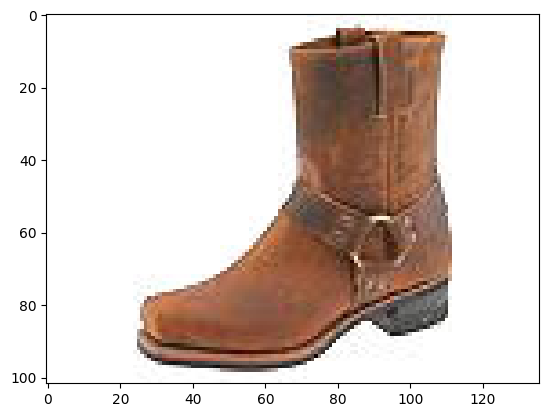

In [21]:
image, label = dataset[0]
print(f"Clase: {classes[label]}")
print(f"Dimensiones de la imagen: {image.size}")
plt.imshow(image)
plt.show()

In [7]:
labels = []
img_sizes = []
for i in range(len(dataset)):
    img, label = dataset[i]
    labels.append(classes[label])
    img_sizes.append(img.size)


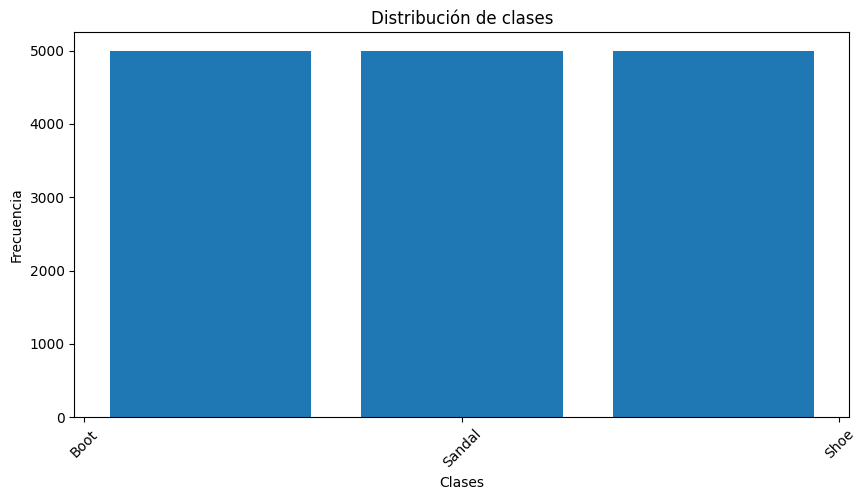

In [8]:
plt.figure(figsize=(10, 5))
plt.hist(labels, bins=len(classes), rwidth=0.8)
plt.xticks(rotation=45)
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.title("Distribución de clases")
plt.show()


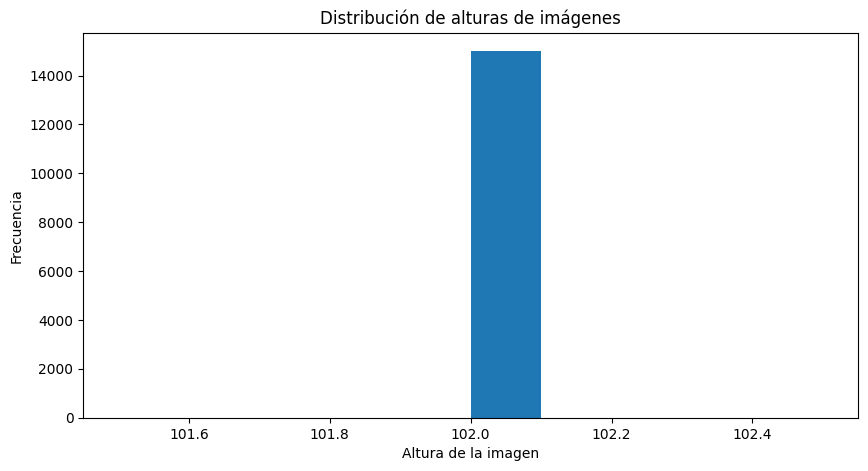

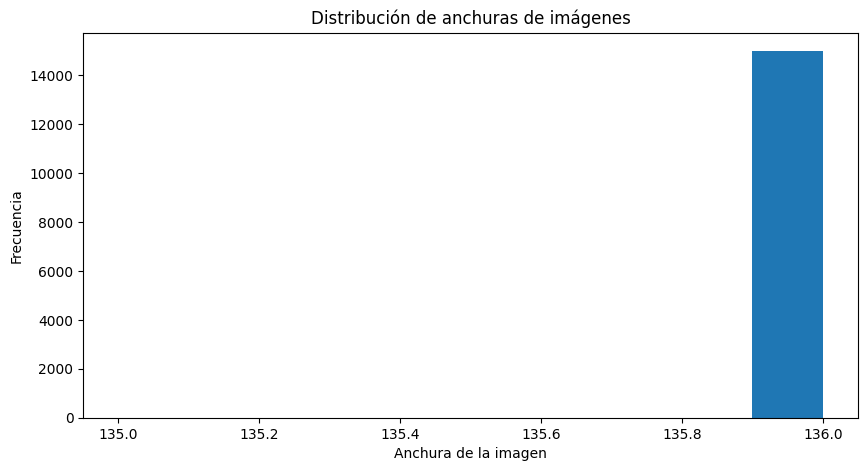

In [11]:
img_heights = [img[1] for img in img_sizes]
img_widths = [img[0] for img in img_sizes]

plt.figure(figsize=(10, 5))
plt.hist(img_heights)
plt.xlabel("Altura de la imagen")
plt.ylabel("Frecuencia")
plt.title("Distribución de alturas de imágenes")
plt.show()
plt.figure(figsize=(10, 5))
plt.hist(img_widths)
plt.xlabel("Anchura de la imagen")
plt.ylabel("Frecuencia")
plt.title("Distribución de anchuras de imágenes")
plt.show()


Al ser iguales, en todo el dataset igualmente se deben ajustar a las dimensiones estándar de 224x224.

In [23]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset = datasets.ImageFolder(dataset_path, transform=transform)

Clase: Boot
Dimensiones de la imagen: <built-in method size of Tensor object at 0x7fe765d1a7f0>


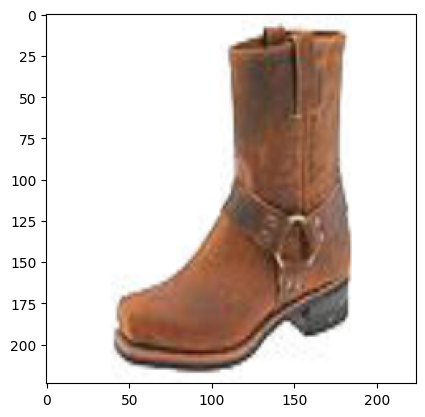

In [26]:
tensor_image, label = dataset[0]
print(f"Clase: {classes[label]}")
print(f"Dimensiones de la imagen: {image.size}")
image = tensor_image.permute(1, 2, 0)  # Cambia el orden de los ejes para mostrar la imagen
plt.imshow(image)
plt.show()

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

targets = np.array(dataset.targets)

splits = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=23)

for train_idx, val_idx in splits.split(np.zeros(len(targets)), targets):
    train_indices = Subset(dataset, train_idx)
    val_indices = Subset(dataset, val_idx)

train_dataset = DataLoader(train_indices, batch_size=32, shuffle=True)
val_dataset = DataLoader(val_indices, batch_size=32, shuffle=True)


In [14]:
train_dataset.dataset.dataset.classes

['Boot', 'Sandal', 'Shoe']

## 1.0 Carga de datos con transformaciones

In [ ]:
def download_and_get_dataset():
    path = kagglehub.dataset_download("hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images")
    dataset_path = os.path.join(path, os.listdir(path)[0])
    return dataset_path

Inicialmente se implementó una carga de datos sin augmentación, para verificar que la carga de datos funciona correctamente. En este caso se augmentan los datos para probar la capacidad de generalización del modelo.

In [9]:
def load_data(output_path: str, batch_size: int, test: int = 0.3, transform=None, augmentation=True, all_data=False):

    print("[INFO] Cargando datos")
    #Usamos una augmentación con probabilidades altas, ya que los entrenamientos iniciales mostraron buenos resultados
    augmentation_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(0.8),
        transforms.RandomRotation(30),
        transforms.RandomVerticalFlip(0.6),
    ])

    dataset_path = download_and_get_dataset()
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        #Totensor automáticamente normaliza a [0,1]
        transforms.ToTensor(),
        # Realizamos la augmentación solo si se indica
        augmentation_transform if augmentation else transforms.Lambda(lambda x: x),
        # Normalizamos con los datos sugeridos por ResNet https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet152.html
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    dataset = datasets.ImageFolder(dataset_path, transform=transform)

    targets = np.array(dataset.targets)
    #Separación de test y train en partes iguales para cada clase
    splits = StratifiedShuffleSplit(n_splits=1, test_size=test, random_state=23)

    for train_idx, val_idx in splits.split(np.zeros(len(targets)), targets):
        train_indices = Subset(dataset, train_idx)
        val_indices = Subset(dataset, val_idx)

    train_loader = DataLoader(train_indices, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(val_indices, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

## 1.1 Generación a selección de modelos

Lo siguiente es generar de manera sencilla los modelos para su posterior comparación y que sea de fácil uso y acceso posteriormente

Estrategia 1.1:

Proponemos la siguiente red neuronal "OurNN", un modelo convolucional diseñado para la clasificación de imágenes. Está estructurada de forma modular y busca un equilibrio entre capacidad de aprendizaje y prevención del sobreajuste. Está preparada para recibir imágenes de tamaño 224x224 con 3 canales (RGB) y clasificar en tres categorías.

La arquitectura consta de tres bloques convolucionales. Cada bloque contiene dos capas convolucionales con activación ReLU y normalización por lotes. Después de estas, se aplica una operación de max pooling para reducir la resolución espacial, y un dropout para introducir regularización y evitar el sobreajuste. El número de filtros aumenta con cada bloque: 32 en el primero, 64 en el segundo y 128 en el tercero. Esto permite que las primeras capas capten patrones simples como bordes o colores, y que las capas más profundas aprendan representaciones más complejas como formas o texturas. Se usa un kernel de tamaño 3x3 con padding igual a 1 para mantener las dimensiones espaciales antes del pooling.

Después de pasar por los tres bloques, la resolución de la imagen se reduce de 224x224 a 28x28. El resultado, con 128 canales, se aplana para pasar al clasificador. Este consiste en una capa densa de 256 unidades con activación ReLU y dropout del 50%, seguida de una capa final con tantas unidades como clases. Esta capa de salida produce los logits que permiten hacer la clasificación final.

En resumen, la red separa claramente la extracción de características de la clasificación final. Utiliza técnicas comunes y efectivas como batch normalization, dropout y ReLU para mejorar el rendimiento y la estabilidad del entrenamiento [1]. Es un modelo sencillo pero funcional, apropiado para tareas de clasificación con imágenes de resolución estándar y conjuntos de datos de complejidad moderada.


In [27]:
class OurNN(nn.Module):
    def __init__(self,input_size=224, input_channels=3, num_classes=3):
        super().__init__()

        # Variables configurables
        filters_block1 = 32
        filters_block2 = 64
        filters_block3 = 128
        dropout_conv = 0.25
        dropout_fc = 0.5
        fc_units = 256
        kernel_size = 3
        pool_kernel_size = 2
        padding = 1

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(input_channels, filters_block1, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(filters_block1),
            nn.ReLU(),
            nn.Conv2d(filters_block1, filters_block1, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(filters_block1),
            nn.ReLU(),
            nn.MaxPool2d(pool_kernel_size),
            nn.Dropout(dropout_conv)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(filters_block1, filters_block2, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(filters_block2),
            nn.ReLU(),
            nn.Conv2d(filters_block2, filters_block2, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(filters_block2),
            nn.ReLU(),
            nn.MaxPool2d(pool_kernel_size),
            nn.Dropout(dropout_conv)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(filters_block2, filters_block3, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(filters_block3),
            nn.ReLU(),
            nn.Conv2d(filters_block3, filters_block3, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(filters_block3),
            nn.ReLU(),
            nn.MaxPool2d(pool_kernel_size),
            nn.Dropout(dropout_conv)
        )

        flattened_size = filters_block3 * (input_size // (pool_kernel_size ** 3)) **2

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, fc_units),
            nn.ReLU(),
            nn.Dropout(dropout_fc),
            nn.Linear(fc_units, num_classes)
        )



    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.classifier(x)
        return x


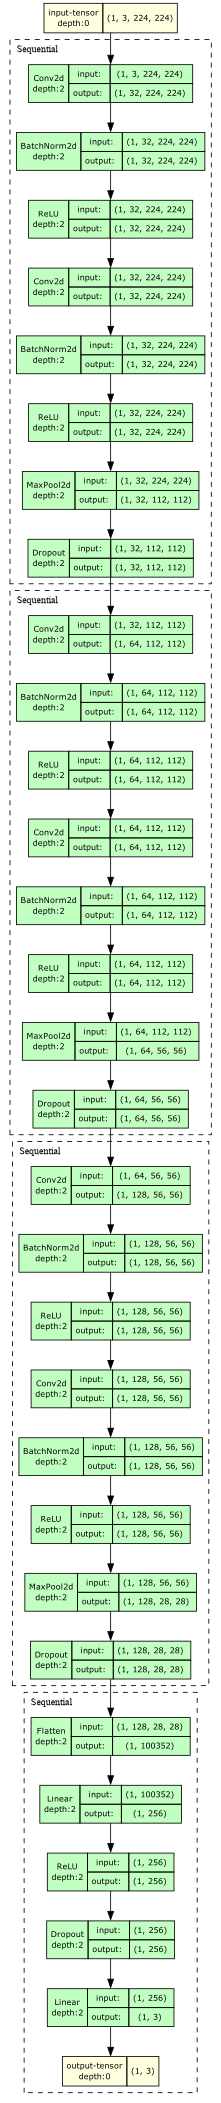

In [42]:
from torchview import draw_graph
import io

model_graph = draw_graph(OurNN(), input_size=(1,3,224,224), expand_nested=True)
png_bytes = model_graph.visual_graph.pipe(format="png")
image = Image.open(io.BytesIO(png_bytes))
display(image)


#### Estrategia 1.2:

En este caso se implementan adicionalmente a compresiones de información anteriormente mencionadas conexiones entre capas y concatenaciones de las mismas, siguiendo la idea principal de ResNet [2], de esta manera conectando capas externas de la red con las más profundas para no perder matices de información y así evitar el desvanecimiento de gradiente.

Además de combinar conceptos de concatenación y re dimensionamiento de matrices como es en el caso de conv4 y conv5 a conv6 y conv7, lo que ayuda a la diversificación de características y retención de información a capas profundas [3].

De manera final se aplica un AvgPool2d, seguido de capas completamente conectadas tratando que no se den cambios drásticos en las dimensiones para conservar la compresión de la información y que las capas de clasificación puedan obtener mejores resultados.


In [36]:
import torch.nn.functional as F
class CNNConnectedDeep(nn.Module):
    def __init__(self, num_classes=3):
        super(CNNConnectedDeep, self).__init__()

        # Primeras capas
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)

        # Concatenación de conv1 y conv3
        # 32 (resized conv1) + 64 = 96
        # Bloques de compresión adicionales con conexiones
        self.conv4 = nn.Conv2d(96, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 160, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(160)

        self.conv6 = nn.Conv2d(160, 192, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(192)

        self.conv7 = nn.Conv2d(192 + 128, 224, kernel_size=3, padding=1)  # concat con out4
        self.bn7 = nn.BatchNorm2d(224)

        self.conv8 = nn.Conv2d(224 + 160, 256, kernel_size=3, padding=1)  # concat con out5
        self.bn8 = nn.BatchNorm2d(256)

        self.global_pool = nn.AdaptiveAvgPool2d((4, 4))  # reduce a [B, 256, 4, 4]

        # Flatten: 256 * 4 * 4 = 4096 → muy alto → reducimos
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        out1 = F.relu(self.bn1(self.conv1(x)))  # [B, 32, 224, 224]
        out2 = F.relu(self.bn2(self.conv2(out1)))
        out2 = out1 + out2  # Residual connection
        out2 = self.pool(out2)  # [B, 32, 112, 112]

        out3 = F.relu(self.bn3(self.conv3(out2)))
        out3 = self.pool(out3)  # [B, 64, 56, 56]

        out1_resized = F.interpolate(out1, size=out3.shape[2:])
        concat1 = torch.cat((out3, out1_resized), dim=1)  # [B, 96, 56, 56]

        # Bloque 4
        out4 = F.relu(self.bn4(self.conv4(concat1)))
        out4 = self.pool(out4)  # [B, 128, 28, 28]

        # Bloque 5
        out5 = F.relu(self.bn5(self.conv5(out4)))
        out5 = self.pool(out5)  # [B, 160, 14, 14]

        # Bloque 6
        out6 = F.relu(self.bn6(self.conv6(out5)))
        out6 = self.pool(out6)  # [B, 192, 7, 7]

        # Concat out4 (resized) con out6
        out4_resized = F.interpolate(out4, size=out6.shape[2:])
        concat2 = torch.cat((out6, out4_resized), dim=1)  # [B, 192+128=320, 7, 7]
        out7 = F.relu(self.bn7(self.conv7(concat2)))

        # Concat out5 (resized) con out7
        out5_resized = F.interpolate(out5, size=out7.shape[2:])
        concat3 = torch.cat((out7, out5_resized), dim=1)  # [B, 224+160=384, 7, 7]
        out8 = F.relu(self.bn8(self.conv8(concat3)))

        x = self.global_pool(out8)  # [B, 256, 4, 4]
        x = x.view(x.size(0), -1)   # Flatten → [B, 4096]

        x = self.dropout(F.relu(self.fc1(x)))  # 4096 → 512
        x = self.dropout(F.relu(self.fc2(x)))  # 512 → 128
        out = self.fc3(x)  # 128 → num_classes

        return out


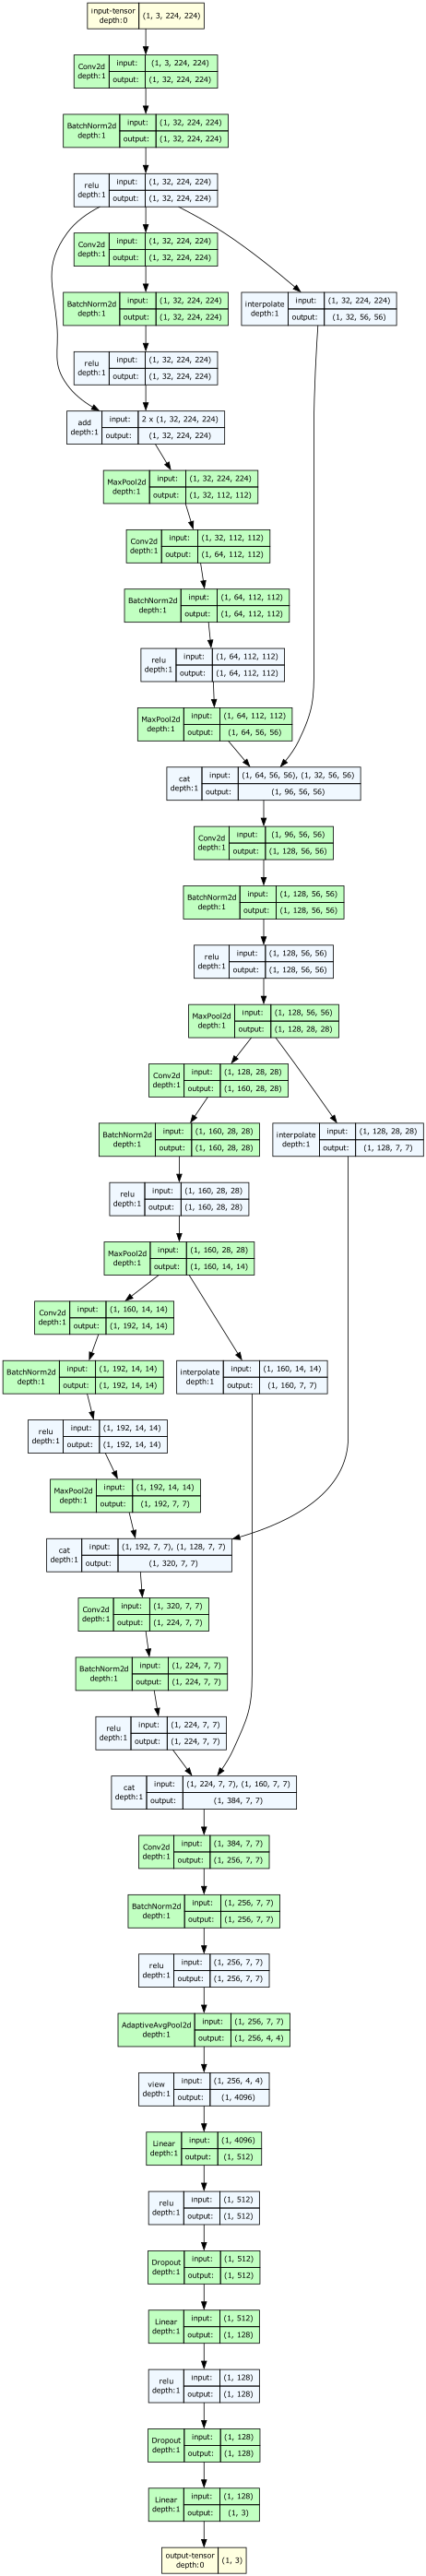

In [43]:
model_graph = draw_graph(CNNConnectedDeep(), input_size=(1,3,224,224), expand_nested=True)
png_bytes = model_graph.visual_graph.pipe(format="png")
image = Image.open(io.BytesIO(png_bytes))
display(image)

#### Estrategia 2:
En este apartado tomamos modelos basados en redes neuronales preentrenadas:

 1.  **ViTB16**: se trata de un Vision Transformer (ViT) de tipo base que divide la imagen en parches de 16×16 píxeles y aplica una arquitectura de transformer similar a la usada en NLP. Cuenta con 12 bloques, 12 cabezas de atención y 768 dimensiones por token. Puede cargarse con pesos preentrenados en ImageNet para transfer learning, lo que mejora el rendimiento en tareas de clasificación visual. Es una alternativa moderna a las CNN tradicionales y destaca especialmente en datasets grandes o complejos [4].

 2.  **MobileNetV2**: tiene una arquitectura basada en un diseño optimizado para eficiencia: utiliza bloques inverted residual con linear bottlenecks. En lugar de expandir y luego reducir como una CNN normal, cada bloque primero expande las dimensiones con una convolución 1×1, luego aplica una convolución depthwise separable 3×3 (más ligera que la normal), y finalmente reduce la dimensión otra vez con otra convolución 1×1 [5]. Este diseño permite mantener un bajo número de parámetros y operaciones. Además, hay conexiones residuales (como en ResNet [2]) entre los bloques cuando las dimensiones coinciden, lo que ayuda al flujo del gradiente y mejora el entrenamiento. En total, la red está compuesta por una serie de estos bloques, seguidos de una capa de pooling global y una capa totalmente conectada final para clasificación. Es una arquitectura pensada para ser rápida y precisa al mismo tiempo, ideal para usar en móviles o en tiempo real [5].

3. **MobileNetV3Small**:  El modelo torchvision.models.MobileNetV3Small es una red compacta y eficiente diseñada para dispositivos con recursos limitados. Utiliza bloques inverted residual combinados con módulos squeeze-and-excitation que recalibran la importancia de los canales, y adopta la función de activación hard-swish para optimizar el rendimiento computacional. Gracias a una arquitectura optimizada mediante AutoML, MobileNetV3Small reduce el número de parámetros en comparación con versiones más grandes, lo que la hace ideal para tareas de clasificación en entornos móviles o de bajo consumo. Además, se puede cargar con pesos preentrenados en ImageNet para aprovechar el aprendizaje transferido en aplicaciones reales [6].


In [ ]:
import torch
from torch import nn
import torchvision
from src.utils.engine import set_seed
import torch.nn.functional as F

def get_model(model_name: str) -> nn.Module:
    """Función para obtener el modelo a utilizar en la red neuronal. Se pueden agregar más modelos a medida que se necesiten"""

    if model_name == "tinyvgg":
        model = TinyVGG(input_shape=1, hidden_units=64, output_shape=2)
        return model

    if "custom" in model_name:
        model_name = model_name.split("_")[1]
        if model_name == "effntb0":
            model = create_effntb0()
            return model
        if model_name == "effntb2":
            model = create_effntb2()
            return model
        if model_name == "convnextTiny":
            model = create_convnext_tiny()
            return model
        if model_name == "convnextSmall":
            model = create_convnext_small()
            return model
        if model_name == "resnet50":
            model = create_resnet50()
            return model
        if model_name == "resnet101":
            model = create_resnet101()
            return model
        if model_name == "resnet152":
            model = create_resnet152()
            return model

    match model_name:
        case "our_nn":
            return OurNN()
        case "vit_b_16":
            return create_vit_b_16()
        case "mobilenet_v2":
            return create_mobilenet_v2()
        case "mobilenet_v3_small":
            return  create_mobilenet_v3_small()

    raise NameError("Ingrese un nombre valido")

class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv3d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv3d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv3d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.LayerNorm((7683200,), elementwise_affine=False, eps=1e-5),
            nn.Linear(in_features= 7683200,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


def create_vit_b_16():
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    model = torchvision.models.vit_b_16(weights=weights)
    for param in model.parameters():
        param.requires_grad = False

    set_seed()

    model.heads = nn.Sequential(
        nn.Linear(in_features=768, out_features=256),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 3)
    )
    print("[INFO] create new vit_b_16 model.")
    return model

def create_mobilenet_v2():
    weights = torchvision.models.MobileNet_V2_Weights.DEFAULT
    model = torchvision.models.mobilenet_v2(weights=weights)
    for param in model.features.parameters():
        param.requires_grad = False

    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True),
        torch.nn.Linear(in_features=1280, out_features=3, bias=True)
    )
    print("[INFO] create new mobilenet_v2 model.")
    return model

def create_mobilenet_v3_small():
    weights = torchvision.models.MobileNet_V3_Small_Weights.DEFAULT
    model = torchvision.models.mobilenet_v3_small(weights=weights)
    for param in model.features.parameters():
        param.requires_grad = False

    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True),
        torch.nn.Linear(in_features=576, out_features=3, bias=True)
    )
    print("[INFO] create new mobilenet_v3_small model.")
    return model


def create_effntb0() -> nn.Module:
    #Se obtienen los pesos del model y se cargan
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights)
    model = freeze_parameters(model)
    print("[INFO] create new effntb0 model.")
    return model

def freeze_parameters(model: nn.Module) -> nn.Module:
    """Función para congelar los parámetros de un modelo y así solo entrenar sus capas de clasificación"""
    for param in model.features.parameters():
        param.requires_grad = False

    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True), #Dropout para evitar overfitting
        torch.nn.Linear(in_features=1280, out_features=3, bias=True) # La salida van a ser las 3 clases
    )
    return model

def create_effntb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights)
    for param in model.features.parameters():
        param.requires_grad = False

    set_seed()

    model.classifier = torch.nn.Sequential(
        #En este caso se debe cambiar manualmente el tamaño de la capa de entrada por las propiedades del modelo
        torch.nn.Dropout(p=0.3, inplace=True),
        torch.nn.Linear(in_features=1408, out_features=3, bias=True)
    )
    print("[INFO] create new effntb2 model.")
    return model

def create_convnext_tiny():
    weights = torchvision.models.ConvNeXt_Tiny_Weights.DEFAULT
    model = torchvision.models.convnext_tiny(weights=weights)
    for param in model.features.parameters():
        param.requires_grad = False

    set_seed()

    model.classifier = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.LayerNorm((768,), eps=1e-06, elementwise_affine=True),
        torch.nn.Flatten(start_dim=1, end_dim=-1),
        torch.nn.Linear(in_features=768, out_features=2, bias=True)
    )
    print("[INFO] create new convnext_tiny model.")
    return model

def create_convnext_small():
    weights = torchvision.models.ConvNeXt_Small_Weights.DEFAULT
    model = torchvision.models.convnext_small(weights=weights)
    for param in model.features.parameters():
        param.requires_grad = False

    set_seed()

    model.classifier = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.LayerNorm((768,), eps=1e-06, elementwise_affine=True),
        torch.nn.Flatten(start_dim=1, end_dim=-1),
        torch.nn.Linear(in_features=768, out_features=2, bias=True)
    )
    print("[INFO] create new convnext_small model.")
    return model

def create_resnet50():
    weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
    model = torchvision.models.resnet50(weights=weights)
    for param in model.parameters():
        param.requires_grad = False

    model.fc = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True),
        torch.nn.Linear(in_features=model.fc.in_features, out_features=3, bias=True)
    )
    print("[INFO] create new resnet50 model.")
    return model

def create_resnet101():
    weights = torchvision.models.ResNet101_Weights.IMAGENET1K_V2
    model = torchvision.models.resnet101(weights=weights)
    for param in model.parameters():
        param.requires_grad = False

    model.fc = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True),
        torch.nn.Linear(in_features=model.fc.in_features, out_features=3, bias=True)
    )
    print("[INFO] create new resnet101 model.")
    return model

def create_resnet152():
    weights = torchvision.models.ResNet152_Weights.IMAGENET1K_V2
    model = torchvision.models.resnet152(weights=weights)
    for param in model.parameters():
        param.requires_grad = False

    model.fc = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True),
        torch.nn.Linear(in_features=model.fc.in_features, out_features=3, bias=True)
    )
    print("[INFO] create new resnet152 model.")
    return model


## 1.2.1 Entrenamiento del modelo test

Primero necesitamos un pipeline de entrenamiento, sabemos que la idea general para entrenar una red neuronal es:
- Realizar un forward pass
- Calcular la función de pérdida
- Realizar un backward pass
- Actualizar los pesos
- Repetir el proceso
- Evaluar el modelo
- Guardar el modelo

Adicionalmente a esto se pueden guardar los datos en un tensorboard para su posterior análisis.

In [ ]:
def set_seed(seed: int=23):
    """
    Establece una semilla para la reproducibilidad de los resultados.

    Args:
        seed (int, optional): Semilla a establecer. Por defecto es 23.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def train_func(model: nn.Module, data: torch.utils.data.DataLoader, loss_fn:nn.Module,
               optimizer: torch.optim.Optimizer, device: torch.device):
    #Inicializamos las variables para guardar los resultados
    train_loss, train_acc = 0, 0
    all_preds = []
    all_labels = []
    #Se usa el modelo modo entrenamiento
    model.train()
    #Iteramos sobre el dataset
    for bathc, (X, y) in enumerate(data):
        #Se separan los datos y etiquetas además se cargan en la gpu
        X, y = X.to(device), y.to(device)
        #Realizamos el forward pass
        y_logit = model(X)
        #Calculamos la función de pérdida
        loss = loss_fn(y_logit, y)
        #Se guarda la pérdida
        train_loss += loss.item()
        #Realizamos el backward pass
        optimizer.zero_grad()
        loss.backward()
        #Actualizamos los pesos
        optimizer.step()
        #Calculamos el accuracy y guardamos los resultados
        y_pred = torch.softmax(y_logit, 1).argmax(1) #Recordar que se debe pasar a softmax para obtener la probabilidad
        train_acc += (y_pred == y).sum().item() / len (y_pred)
        all_preds.extend(y_pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
    #Se calcula la pérdida y el accuracy promedio
    train_loss = train_loss / len(data)
    train_acc = train_acc / len(data)

    return train_loss, train_acc, all_preds, all_labels


## 1.2.2 Evaluación del modelo

In [ ]:
def test_func(model: nn.Module, data: DataLoader, loss_fn: nn.Module, device: torch.device):
    #Se pasa el modelo a modo evaluación y así evitar cálculos innecesarios
    model.eval()
    #Inicializamos las variables para guardar los resultados
    test_loss, test_acc = 0, 0
    all_preds = []
    all_labels = []
    #Se usa el inference mode para evitar llevar los gradientes
    with torch.inference_mode():
        #Iteramos sobre el dataset
        for batch, (X, y) in enumerate(data):
            X, y = X.to(device), y.to(device)
            y_logits = model(X)
            #En este caso al ser test no se actualizan los pesos
            loss = loss_fn(y_logits, y)
            test_loss += loss.item()
            y_pred = y_logits.argmax(1)
            #Se guardan las metricas de manera similar a train
            test_acc += (y_pred == y).sum().item() / len (y_pred)
            all_preds.extend(y_pred.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    test_loss = test_loss / len(data)
    test_acc = test_acc / len(data)
    #Devolvemos toda la información para un futuro analisis
    return test_loss, test_acc, all_preds, all_labels


### 1.2.3 Seguimiento de los datos

Como se mencionó anteriormente se usa tensorboard para guardar los datos y así poder analizarlos posteriormente.

In [ ]:
from typing import Dict, List, Tuple
import torch
import os
from torch.utils.data import DataLoader
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, recall_score
import seaborn as sns

def create_write(name: str, model: str, experiment_name: str,extra: str=None) -> SummaryWriter():

    #Se guarda la fecha y hora para crear un directorio único
    timestamp = datetime.now().strftime("%Y-%m-%d")
    #El parametro extra puede ser usado para guardar las epocas o el tipo de modelo
    if extra:
        log_dir = os.path.join("runs", timestamp, experiment_name, name, model, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, name, model)
    print(f"[INFO] create summary writer, saving to: {log_dir}")
    return SummaryWriter(log_dir=log_dir)


### 1.2.4 Selección de optimizador

Se realiza una función para seleccionar un optimizador con la idea que los hiperparametros sean ajustables mediante un json

In [ ]:
def select_optimizer(model: nn.Module, optimizer: str):
    if optimizer == "Adam":
        return torch.optim.Adam(model.parameters(), lr=0.001)
    if optimizer == "SGD":
        return torch.optim.SGD(model.parameters(), lr=0.001)
    if optimizer == "Adamw":
        return torch.optim.AdamW(model.parameters(), lr=0.001)


## 1.2.5 Metricas adicionales para evaluar el modelo

Se adicionan metricas adicionales para tener una mejor comparación del modelo, al ser clasificación se usan métricas como el recall, precision y f1-score.
Además de gráficas como la matriz de confusión para visualizar las clases donde el modelo tiene más dificultad de generalización.

In [ ]:
def plot_confusion_matrix(cm, class_names,title):
    """Plotea la matriz de confusión"""
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.close(fig)
    return fig

### 2 Entrenamiento del modelo

Con todas las funciones anteriores podemos realizar el entrenamiento del modelo. Guardar los resultados e ir ajustando los hiperparametros.

In [ ]:
from torch.optim import lr_scheduler
def train(model: nn.Module, test_data: DataLoader, train_data: DataLoader, loss_fn:nn.Module,
          optimizer: torch.optim.Optimizer, device: torch.device, epochs: int
          , writer: SummaryWriter, title: str) -> Dict[str, List]:

    #Se inicializan las variables para guardar los resultados
    best_test_acc = 0
    best_train_loss = 1000
    best_model = None
    patience_counter = 0


    #Scheduler para reducir el lr con las épocas, muy util cuando se entrenan modelos desde 0
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    #Creamos un diccionario para guardar los resultados y escribirlos más fácilmente
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    #Iteramos entre las epocas
    for epoch in tqdm(range(epochs)):
        #Realizamos el entrenamiento como se muestra en 1.2.1
        train_loss, train_acc,train_preds, train_labes = train_func(
            model,train_data,loss_fn,optimizer, device)
        #Realizamos la evaluación como se muestra en 1.2.2
        test_loss, test_acc, test_preds, test_labels = test_func(
            model, test_data, loss_fn, device)

        #Calculamos las metricas adicionales de cada epoca
        train_f1 = f1_score(train_labes, train_preds, average="weighted")
        test_f1 = f1_score(test_labels, test_preds, average="weighted")
        train_recall = recall_score(train_labes, train_preds, average="weighted")
        test_recall = recall_score(test_labels, test_preds, average="weighted")

        scheduler.step()


        #Imprimimos los resultados para tener un seguimiento en tiempo real
        print(
            "\n"
            f"Epoch {epoch+1} |"
            f"train_loss :{train_loss: .4f} |"
            f"train_acc :{train_acc: .4f} |"
            f"test_loss :{test_loss: .4f} |"
            f"test_acc :{test_acc: .4f} |"
            f"train_f1_w :{train_f1: .4f} |"
            f"test_f1_w :{test_f1: .4f} |"
            f"train_recall :{train_recall: .4f} |"
            f"test_recall :{test_recall: .4f} "
        )
        #Guardamos los resultados en el diccionario
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)



        ##Se agregan los resultados a tensorboard para su posterior análisis, y como parametro se guardan las epocas
        if writer:
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={"train_loss": train_loss, "tests_loss": test_loss},
                               global_step=epoch
                               )

            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={"train_acc": train_acc, "tests_acc": test_acc},
                               global_step=epoch
                               )

            writer.add_scalars(main_tag="F1_weighted",
                               tag_scalar_dict={"train_f1_w": train_f1, "tests_f1_w": test_f1},
                               global_step=epoch
                               )

            writer.add_scalars(main_tag="Recall_weighted",
                               tag_scalar_dict={"train_recall": train_recall, "tests_recall": test_recall},
                               global_step=epoch
                               )

            # Se agrega la matriz de confusión al final del test
            if epoch == epochs - 1:
                cm = confusion_matrix(test_preds, test_labels)
                cm_fig = plot_confusion_matrix(cm, train_data.dataset.dataset.classes, title)
                writer.add_figure("Confusion Matrix", cm_fig, global_step=epoch)

            if patience_counter > 5:
                print(f"[INFO] Early stopping at epoch {epoch+1}")
                cm = confusion_matrix(test_preds, test_labels)
                cm_fig = plot_confusion_matrix(cm, train_data.dataset.dataset.classes, title)
                writer.add_figure("Confusion Matrix", cm_fig, global_step=epoch)
                break


        # Para guardar el mejor modelo
        if test_acc > best_test_acc and train_loss < best_train_loss:
            best_test_acc = train_acc
            best_train_loss = train_loss
            best_model = model.state_dict()
        else:
            patience_counter += 1

    return results, best_model, best_test_acc, cm_fig, test_loss


### 3 Generación de experimentos

Ahora que tenemos una forma fácil de entrenar distintos modelos, se requiere una función con la cual realizar variaciones y experimentos.

In [ ]:
def run_experiments(test_dataloader: DataLoader, train_dataloader: DataLoader, parameters: dict, w_loss= False):

    #Se limpia la memoria de la gpu para evitar problemas de memoria
    torch.cuda.empty_cache()

    #Se establece el dispositivo a usar, en este caso la gpu aunque depende del hardware
    device = "cuda" if torch.cuda.is_available() else "cpu"
    set_seed()


    #Se obtienen los parametros del json
    experiment_name = parameters["name"]
    num_epochs = parameters["epochs"]
    optimizers = parameters["optimizers"]
    experiment_number = 0

    # Como es una clasificación multiclase se usa la función de pérdida de entropía cruzada, además que las clases estan balanceadas
    if w_loss:
        #Se implementa una variación de pesos de clase solo como prueba
        loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([2.0, 1.0, 1.0])).to(device) #El doble de peso para los 0
    else:
        loss_fn = nn.CrossEntropyLoss().to(device)
    conf_mat = []

    #Se itera primero entre los modelos
    for model_name in parameters["models"]:
        best_test_acc = 0
        best_checkpoint = None
        best_test_loss = 1000
        #Se itera entre la cantidad de epocas
        for epochs in num_epochs:
            #Se itera entre los optimizadores
            for optimizer_name in optimizers:
                experiment_number += 1
                print(f"[INFO] Experiment number: {experiment_number}")
                print(f"[INFO] model: {model_name}")
                print(f"[INFO] Optimizer: {optimizer_name}")
                print(f"[INFO] Epochs: {epochs}")
                #Usando al funcion de modelo se obtiene por su nombre y se carga en la gpu
                model = get_model(model_name).to(device)
                #Se crea el writer para guardar los resultados
                writer = create_write(name=optimizer_name,
                                      model=model_name, experiment_name=experiment_name, extra=str(epochs))
                #Se selecciona el optimizador
                optimizer = select_optimizer(model, optimizer_name)
                #Se realiza el entrenamiento y se obtienen los resultados para guardar el mejor modelo
                results, best_model, test_acc, cm_fig, test_loss = train(model, test_dataloader, train_dataloader, loss_fn, optimizer, device,
                                                                         epochs, writer, experiment_name + "/" + model_name + "/" + optimizer_name + "/" + str(epochs))
                print("-" * 50 + "\n")

                # Cada epoca se guardan los resultados y el mejor modelo
                if test_loss < best_test_loss:
                    best_test_acc = test_acc
                    best_checkpoint = best_model
                    best_optimizer = optimizer_name
                    best_epochs = epochs
                    best_model_name = model_name
                    best_test_loss = test_loss

            conf_mat.append(cm_fig)
        # Se guarda un modelo como checkpoint para así evitar el overfitting y facilitar su carga
        if best_checkpoint:
            print(f"[INFO] Best model: {best_model_name} with optimizer: {best_optimizer} and epochs: {best_epochs}")
            path = f"./models/{experiment_name}/{best_model_name}/{best_optimizer}/{best_epochs}"
            os.makedirs(path, exist_ok=True)
            torch.save(best_checkpoint, path + f"/best_model_{best_model_name}.pth")

    torch.cuda.empty_cache()
    return conf_mat


## 4 pipeline

Se une todas las funciones anteriores, con la idea de que los experimentos sean manejados a traves de un json

In [ ]:
import json
def pipeline(output_folder, inference_path):
    with open("parameters.json", "r",encoding="utf-8") as file:
        parameters = json.load(file)

    AUGMENTATION = True
    ALL_DATA = False
    WEIGHTED_LOSS = False

    if "no_augmentation" in parameters:
        AUGMENTATION = False
        WEIGHTED_LOSS = True

    if "no_all_data" in parameters:
        ALL_DATA = False
        WEIGHTED_LOSS = True

    print("[INFO] Creando dataloaders")
    train_loader, test_loader = load_data(output_folder, parameters["batches"],
                                          augmentation=AUGMENTATION, all_data=ALL_DATA)
    print("[INFO] Dataloaders creados")


    print("[INFO] Iniciando entrenamiento")
    run_experiments(test_loader, train_loader, parameters, w_loss=False)
    print("[INFO] Entrenamiento finalizado")

    return

In [ ]:
OUTPUT_PATH = "output/"
INFERENCE_PATH = "inference/"

pipeline(OUTPUT_PATH, INFERENCE_PATH)



## 5. Métodología de experimentos



Inicialmente, se establecen los batches de entrenamiento, mediante el entrenamiento de resnet152 durante 5 épocas con Adam, variando los tamaños de 32, 64 y 256, pero en este caso al ser un dataset de 15000 para poder realizar pruebas rápidas y teniendo en cuenta los tiempos de entrenamiento y su estabilidad se deciden por batches de 256.

De esta forma inicialmente se realizaron pruebas mediante fine-tuning realizando las combinaciones posibles basadas en la siguiente tabla:

$$
\begin{array}{|l|l|}
\hline
\textbf{Ítem} & \textbf{Hiperparametros} \\
\hline
\text{Modelo} & \text{[efficientnetb2, resnet101, resnet152, vit-b-16, mobilnet-v2, mobilenet-v3-small]} \\
\hline
\text{Épocas} & 5 \\
\hline
\text{Optimizador} & \text{[AdamW, SGD, Adam]} \\
\hline
\end{array}
$$



Y al encontrar el mejor optimizador de estos se procede a realizar una prueba con respecto a las épocas aumentando a 15, 20 y 30, para así evaluar su estabilidad y su capacidad de generalización.

Por otra parte, para la estrategia 1 se realizaron pruebas con respecto a la siguiente tabla, incrementando las épocas a 8 debido a su inestabilidad al entrenar todos sus pesos.


$$
\begin{array}{|l|l|}
\hline
\textbf{Ítem} & \textbf{Hiperparametros} \\
\hline
\text{Modelo} & \text{[cnnconnecteddeep, our-nn]} \\
\hline
\text{Épocas} & 5, 8 \\
\hline
\text{Optimizador} & \text{[AdamW, SGD, Adam]} \\
\hline
\end{array}
$$

De estos se toman los mejores modelos con su respectivo optimizador y se entrenan adicionalmente 15, 20 y 30 épocas evaluando su estabilidad y métricas

## 6. Evaluación y comparación

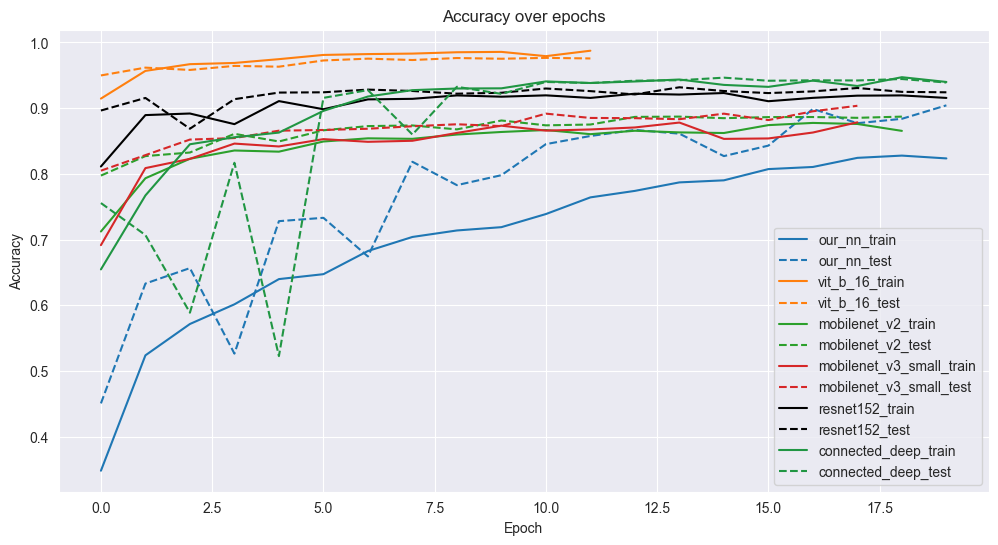

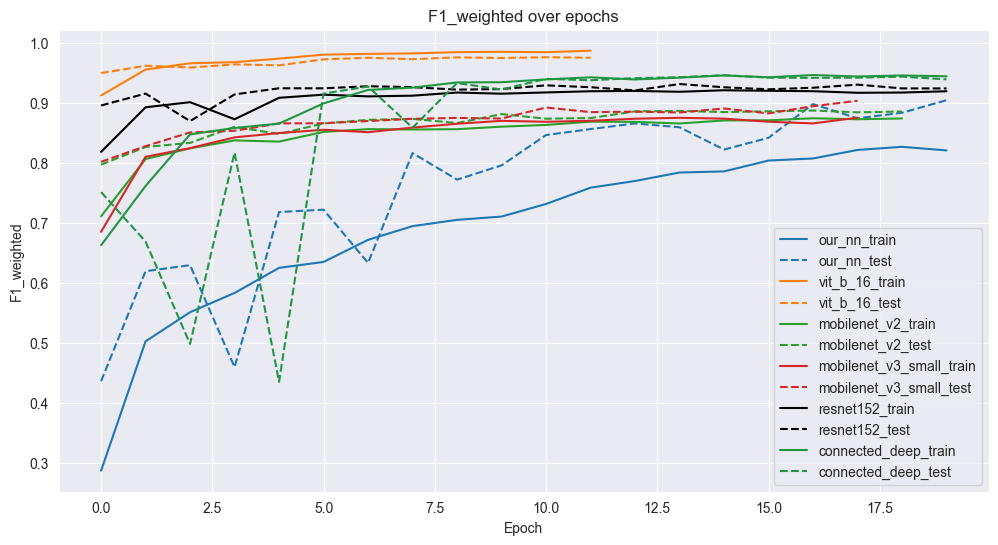

In [39]:
from tensorboard.backend.event_processing import event_accumulator
import os
import matplotlib.pyplot as plt

models = ["our_nn", "vit_b_16", "mobilenet_v2", "mobilenet_v3_small", "resnet152", "connected_deep"]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', '#000000', "#209643"]  # define un color por modelo

def plot_stat(stat, path_train, path_test):

    fig, ax = plt.subplots(figsize=(12, 6))
    for i, model in enumerate(models):
        # Paths
        # train_dir = f"shoe_classify/runs/{model}/{path_train}"
        # test_dir = f"shoe_classify/runs/{model}/{path_test}"
        train_dir = f"./runs1/{model}/{path_train}"
        test_dir = f"./runs1/{model}/{path_test}"

        # Encontrar archivos train
        event_train_file = None
        for subdir, dirs, files in os.walk(train_dir):
            for file in files:
                if file.startswith("events.out.tfevents"):
                    event_train_file = os.path.join(subdir, file)
                    break
            if event_train_file:
                break

        # Encontrar archivos test
        event_test_file = None
        for subdir, dirs, files in os.walk(test_dir):
            for file in files:
                if file.startswith("events.out.tfevents"):
                    event_test_file = os.path.join(subdir, file)
                    break
            if event_test_file:
                break

        # Cargar y graficar train
        ea_train = event_accumulator.EventAccumulator(event_train_file)
        ea_train.Reload()
        train_acc = ea_train.Scalars(stat)
        steps_train = [x.step for x in train_acc]
        values_train = [x.value for x in train_acc]
        ax.plot(steps_train, values_train, label=f"{model}_train", color=colors[i], linestyle='-')

        # Cargar y graficar test
        ea_test = event_accumulator.EventAccumulator(event_test_file)
        ea_test.Reload()
        test_acc = ea_test.Scalars(stat)
        steps_test = [x.step for x in test_acc]
        values_test = [x.value for x in test_acc]
        ax.plot(steps_test, values_test, label=f"{model}_test", color=colors[i], linestyle='--')

    ax.set_title(f"{stat} over epochs")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(f"{stat}")
    ax.grid(True)
    ax.legend()
    plt.show()

plot_stat("Accuracy", "Accuracy_train_acc","Accuracy_tests_acc")
plot_stat("F1_weighted", "F1_weighted_train_f1_w", "F1_weighted_tests_f1_w")


Las gráficas muestran que todos los modelos alcanzan valores de accuracy por encima de 0.8.

Algunas métricas de test son ligeramente mejores que las de entrenamiento, esto puede deberse a la regularización, data augmentation o el dropout. También es un indicio de que los modelos no están sobre ajustado.

Las métricas de precisión para todos los modelos (a excepción de "our_nn") aumentan de forma constante, alcanzando valores cercanos al 99% en entrenamiento y al 98% en test para ViTB16 y de 94 % para "connected_deep_train". Asimismo, las métricas de F1 y recall muestran un comportamiento paralelo y consistente entre ambos conjuntos, con valores cercanos al 0.98 al final del entrenamiento. Esto refleja que el modelo logra un buen equilibrio entre precisión y cobertura.

Para el caso de los modelos Mobilenet (V2 y V3 Small), se puede decir que el resultado es bueno, aunque no tanto en comparación con otros modelos probados en este proyecto. Las métricas de accuracy, F1 y recall son consistentes tanto para el conjunto de entrenamiento (0.87) como para el de test (0.9). Esto indica que no hay clases dominantes que estén sesgando la evaluación, ya que F1-weighted y recall-weighted están alineadas.

Podemos destacar que en el modelo más simple que proponemos ("our_nn") con cada iteración los valores de F1 y recall aumentan desde valores nulos hasta obtener un recall de 0.9 en con los datos de aprendizaje. Se puede observar que la tasa de mejora con cada época se va aplanando, si bien es cierto que podríamos aumentar quizá el número de épocas para llegar a un valor estable de recall, si lo aumentamos demasiado caeríamos en un problema de sobre ajuste.


Todas las métricas de test son ligeramente mejores que las de entrenamiento, esto puede deberse a la regularización, el data augmentation o el dropout. También es un indicio de que el modelo no está sobre ajustado.

A partir de las gráficas podemos determinar dos mejores modelos son ViTB16 y nuestra connected deep. Las matrices de confusión de estos dos últimos modelos son:

Model: vit_b_16
Figure tags: ['Confusion Matrix']


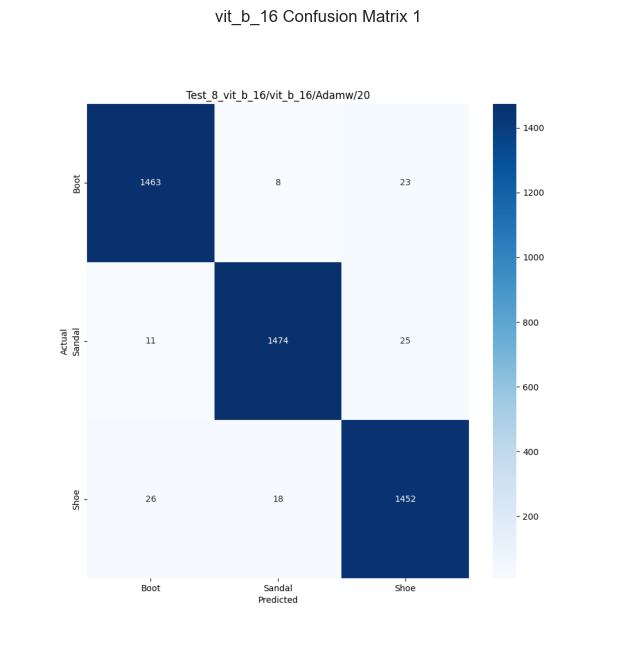

Model: connected_deep
Figure tags: ['Confusion Matrix']


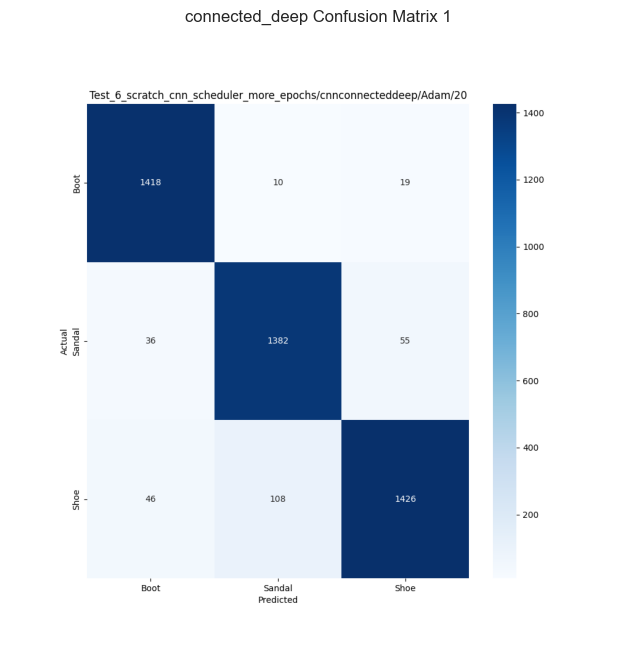

In [40]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import io
from PIL import Image

models = ["vit_b_16","connected_deep"]

for model in models:
    # dir = f"shoe_classify/runs/{model}"
    dir = f"./runs1/{model}"
    event_file = ""
    for subdir, dirs, files in os.walk(dir):
        for file in files:
            if file.startswith("events.out.tfevents"):
                event_file = os.path.join(subdir, file)
                break
        if event_file:
            break

    ea = event_accumulator.EventAccumulator(event_file)
    ea.Reload()

    print(f"Model: {model}")
    print("Figure tags:", ea.Tags().get('images', []))  # Asegúrate que 'images' es la clave correcta

    figures = ea.Images('Confusion Matrix')

    num_figs_to_show = 2
    figs_to_show = figures[-num_figs_to_show:] if len(figures) >= num_figs_to_show else figures

    for i, fig in enumerate(figs_to_show, 1):
        fig_data = fig.encoded_image_string
        image = Image.open(io.BytesIO(fig_data))
        plt.figure(figsize=(10, 8))
        plt.title(f"{model} Confusion Matrix {i}")
        plt.imshow(image)
        plt.axis('off')
        plt.show()


## 7. Conclusiones



A partir del análisis de las métricas del modelo de clasificación ViTB16, se concluye que el entrenamiento ha sido exitoso, ya que la loss en entrenamiento disminuye consistentemente desde 0.27 hasta aproximadamente 0.03, lo que indica una buena capacidad de aprendizaje. De forma similar, la loss en el conjunto de prueba también muestra una tendencia descendente desde 0.16 hasta alrededor de 0.06, lo que sugiere una mejora sostenida en la capacidad de generalización del modelo.

No se observan signos claros de overfitting, aunque en las últimas épocas la pérdida en entrenamiento continúa disminuyendo, las métricas en el conjunto de prueba se mantienen estables o siguen mejorando levemente, lo cual sugiere que el modelo no está perdiendo capacidad de generalización a medida que entrena más.

Además, podemos destacar que el modelo converge a una buena solución en muy pocas épocas (a partir de la octava ya se estabiliza)

En conclusión, es un modelo que está aprendiendo bien, generaliza incluso mejor y no existen señales de overfitting.

Respecto al modelo "deep connected" propuesto por nosotros, obtenemos muy buenos resultaso. La arquitectura propuesta demuestra una capacidad notable para preservar y aprovechar la información a lo largo de la red mediante el uso de conexiones residuales y concatenaciones estratégicas entre capas. Esta combinación ha permitido mitigar eficazmente el problema del desvanecimiento del gradiente y mejorar la representación de características en capas profundas. La inclusión de mecanismos de re dimensionamiento y compresión progresiva ha favorecido una extracción de características más robusta y diversa, lo que se traduce en un mejor rendimiento en tareas de clasificación. Los resultados obtenidos, superiores a los de otros modelos comparativos, confirman la eficacia del enfoque adoptado y validan la integración de técnicas inspiradas en ResNet junto con estrategias de compresión estructurada.


### Bibliografía

[1]	I. Konovalenko, P. Maruschak, J. Brezinová, O. Prentkovskis, y J. Brezina, «Research of U-Net-Based CNN Architectures for Metal Surface Defect Detection», Machines, vol. 10, n.o 5, Art. n.o 5, may 2022, doi: 10.3390/machines10050327.

[2]	K. He, X. Zhang, S. Ren, y J. Sun, «Deep Residual Learning for Image Recognition», 10 de diciembre de 2015, arXiv: arXiv:1512.03385. doi: 10.48550/arXiv.1512.03385.

[3]	G. Huang, Z. Liu, L. van der Maaten, y K. Q. Weinberger, «Densely Connected Convolutional Networks», 28 de enero de 2018, arXiv: arXiv:1608.06993. doi: 10.48550/arXiv.1608.06993.

[4]	A. Dosovitskiy et al., «An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale», 3 de junio de 2021, arXiv: arXiv:2010.11929. doi: 10.48550/arXiv.2010.11929.

[5]	M. Sandler, A. Howard, M. Zhu, A. Zhmoginov, y L.-C. Chen, «MobileNetV2: Inverted Residuals and Linear Bottlenecks», 21 de marzo de 2019, arXiv: arXiv:1801.04381. doi: 10.48550/arXiv.1801.04381.

[6]	A. Howard et al., «Searching for MobileNetV3», 20 de noviembre de 2019, arXiv: arXiv:1905.02244. doi: 10.48550/arXiv.1905.02244.

[7]	D. Masters y C. Luschi, «Revisiting Small Batch Training for Deep Neural Networks», 20 de abril de 2018, arXiv: arXiv:1804.07612. doi: 10.48550/arXiv.1804.07612.